In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
# import seaborn as sns
import time

import models
import flows

In [108]:
N = 25
data = sio.loadmat("case3.mat")
x1 = data["x1"]
x2 = data["x2"]
y1 = data["y1"]
y2 = data["y2"]
w1 = data["w1"]
w2 = data["w2"]
A = data["A"]
k = data["k"]

x1_train = x1[0, :].reshape([-1, 1])
y1_train = y1[:N].T
x2_train = x2[0, :].reshape([-1, 1])
y2_train = y2[:N].T
w1_train = w1[:N]
w2_train = w2[:N]
A1_train = A[:N]
A2_train = A[2000:2000+N]
k1_train = k[:N]
k2_train = k[2000:2000+N]

In [109]:
meta = models.Meta(num_tasks=2*N, dim=50, eps=0.0, scale=0.05)

In [110]:
loss = meta.train(
    x1_train,
    y1_train,
    x2_train,
    y2_train,
    niter=50000,
    ftol=1e-10,
)

0 6.770296 , time:  0.22420215606689453
1000 0.07691591 , time:  0.8396246433258057
2000 0.0017928423 , time:  0.9183266162872314
3000 0.00051854295 , time:  0.8310775756835938
4000 0.00022081114 , time:  0.8830022811889648
5000 0.0001239522 , time:  0.9391975402832031
6000 7.425097e-05 , time:  0.8545255661010742
7000 5.8952166e-05 , time:  0.906304121017456
8000 2.9949857e-05 , time:  0.9170162677764893
9000 2.0657822e-05 , time:  0.8274824619293213
10000 1.5442693e-05 , time:  0.8922057151794434
11000 0.00085659383 , time:  0.9119751453399658
12000 1.168107e-05 , time:  0.8269035816192627
13000 8.758513e-06 , time:  0.840712308883667
14000 1.3135654e-05 , time:  0.9050753116607666
15000 0.00031365023 , time:  0.8267021179199219
16000 6.0796324e-06 , time:  0.8259966373443604
17000 2.470269e-05 , time:  0.8337092399597168
18000 5.103742e-06 , time:  0.9021987915039062
19000 9.639831e-05 , time:  0.8333148956298828
20000 2.2834029e-05 , time:  0.8903577327728271
21000 0.0001291523 , t

In [111]:
meta.restore()
loss[-1], min(loss)

(6.7644332e-06, 1.4272674e-06)

In [112]:
permutation = list(np.arange(26, 51, 1)) + list(np.arange(0, 26, 1))

nf = flows.MAF(
    dim=51,
    permutation=permutation,
    hidden_layers=[128, 128],
    num_bijectors=10,
    activation=tf.nn.relu,
)

In [113]:
heads = meta.heads.numpy().T
data = heads
data = np.tile(data, [1000//N//2, 1])
print(data.shape)

(1000, 51)


In [114]:
loss = nf.train_batch(tf.constant(data, tf.float32), nepoch=500)

0 22.891363
1 -15.243041
2 -39.275295
3 -56.207584
4 -71.98749
5 -76.16873
6 -83.77705
7 -92.42665
8 -93.81437
9 -100.4015
10 -106.19476
11 -91.30294
12 -92.45119
13 -103.68377
14 -111.90138
15 -113.63983
16 -113.844826
17 -124.23236
18 -127.95761
19 -111.05744
20 -126.53886
21 -122.145935
22 -128.82379
23 -129.89429
24 -134.37076
25 -123.59433
26 -134.42188
27 -136.43088
28 -138.91814
29 -122.62446
30 -136.88875
31 -98.90916
32 -110.44744
33 -127.505486
34 -141.8281
35 -104.3927
36 -111.01977
37 -126.04167
38 -141.47504
39 -119.12034
40 -135.72324
41 -145.3064
42 -103.37141
43 -107.059326
44 -120.92508
45 -136.13567
46 -147.54254
47 -108.56696
48 -117.603516
49 -128.65512
50 -139.67542
51 -146.10786
52 -146.06029
53 -153.72147
54 -96.83954
55 -140.19904
56 -146.70255
57 -156.43773
58 -131.4374
59 -141.31367
60 -153.40688
61 -143.70078
62 -162.75385
63 -136.75435
64 -149.67328
65 -159.35667
66 -160.92647
67 -105.67578
68 -111.317184
69 -120.443245
70 -133.68678
71 -147.22633
72 -157.43

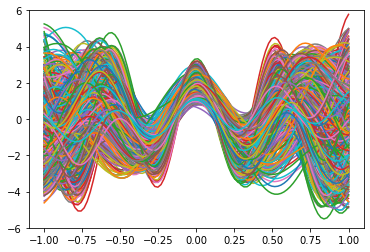

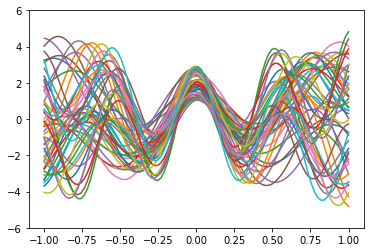

In [115]:
nf.restore()
# sample_fn = tf.function(nf.sample)
# heads = (sample_fn(1000) + 0.5) * (heads_max.reshape([1, -1]) - heads_min.reshape([1, -1])) + heads_min.reshape([1, -1])
# heads = sample_fn(1000).numpy() * std_heads / scale + mu_heads
heads = nf.sample(1000)
x_test = tf.constant(np.linspace(-1, 1, 100).reshape([-1, 1]), tf.float32)
# y_test = tf.constant(y_train, tf.float32)

out = meta.call(x_test, tf.transpose(heads))
for i in range(1000):
    plt.plot(x_test, out[:, i])
plt.ylim([-6, 6])

plt.figure()
out = meta.call(x_test, meta.heads)
for i in range(50):
    plt.plot(x_test, out[:, i])
plt.ylim([-6, 6])
plt.show()

In [116]:
# np.random.seed(1234) # for case 1
# np.random.seed(6666) # for case 2
# np.random.seed(666)
np.random.seed(123)
x_test = np.linspace(-1, 1, 100).reshape([-1, 1])
idx = np.random.choice(100, 100, replace=False)[:4]
x_train = x_test[idx, :]
A = 3
w = 4 * np.pi
k = 1
y_train = A * np.cos(w * x_train) + 2 * k * x_train
y_test = A * np.cos(w * x_test) + 2 * k * x_test

In [119]:
model = models.Model2(body=meta, flow=nf, dim=50, eps=0.0001)
loss = model.train(x_train, y_train, niter=20000)

0 6.8437147
1000 0.49812296
2000 0.10728568
3000 0.043834552
4000 0.025709674
5000 0.023888342
6000 0.02298784
7000 0.00489973
8000 0.0021351427
9000 0.0018995802
10000 0.0019076734
11000 0.0018963537
12000 0.001905824
13000 0.0019026094
14000 0.0018999189
15000 0.0019149608
16000 0.0019255123
17000 0.0019119799
18000 0.0019116674
19000 0.0019017304


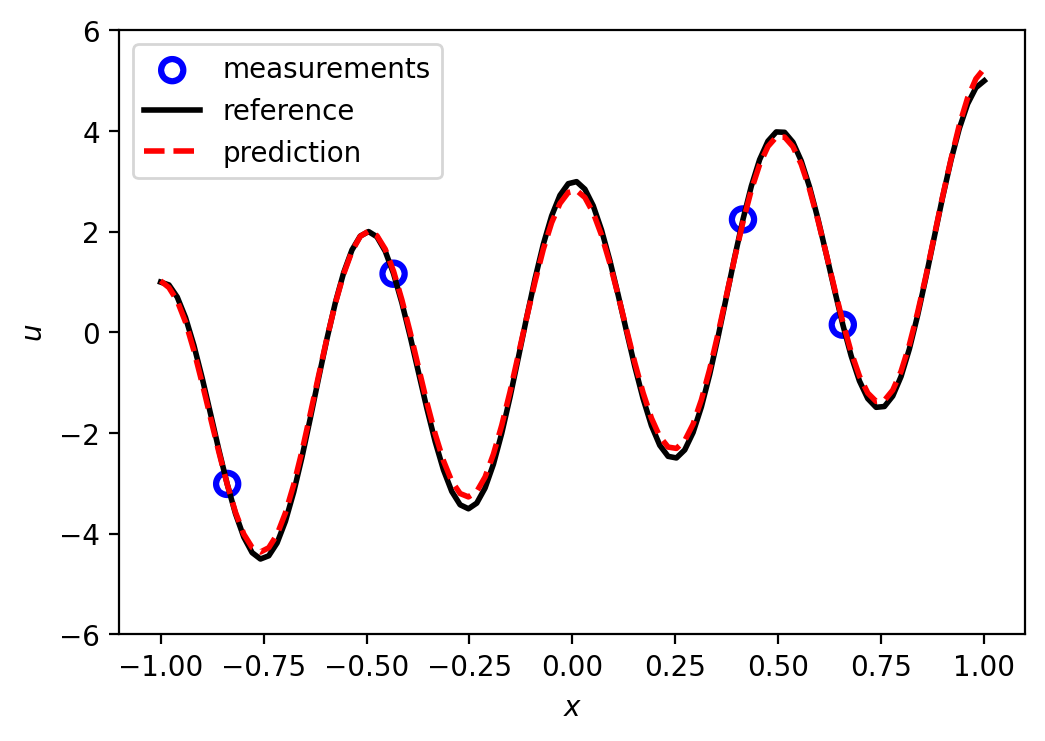

In [121]:
# model.restore()
y_pred = meta.call(tf.constant(x_test, tf.float32), model.head)

fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.scatter(x_train, y_train, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test, y_test, color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test, y_pred.numpy(), color="red", linestyle="--", linewidth=2, label="prediction")
ax.legend(loc=0)
ax.set_ylim([-6, 6])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_box_aspect(2/3)
# ax.set_title("1000 historical tasks")
fig.savefig("case_3_50.png")
# plt.show()